In [ ]:
import subprocess, json
from coffea.nanoevents import NanoAODSchema
from coffea import processor
import uproot

import awkward as ak
import numpy as np
import dask
import hist
import matplotlib.pyplot as plt
import mplhep as hep

hep.style.use('CMS')

In [2]:
MWprime = 900
MDarkHiggs = 250
n_files = 309

In [3]:
#cmsdata
#xrd_protocol = 'root://cmsdata.phys.cmu.edu/'
#path = '/store/user/jgaytanv/MWprime'+str(MWprime)+'_MDarkHiggs'+str(MDarkHiggs)+'/'
#lxplus
xrd_protocol = 'root://eosuser.cern.ch/'
path = '/eos/user/j/jgaytanv/Wprime_DarkHiggs/nanoAODs/MWprime'+str(MWprime)+'_MDarkHiggs'+str(MDarkHiggs)+'/'

cmds_for_subprocess = ['xrdfs', xrd_protocol, 'ls', path]
result = subprocess.run(cmds_for_subprocess, capture_output=True, text=True)
files = result.stdout.splitlines()

nanoaods = {'signal': []}
for ifile in files[0:n_files]:
    if '.root' in ifile:
        # root://cmseos.fnal.gov/"
        nanoaods['signal'].append(xrd_protocol+ifile)

with open('input.json', 'w') as outfile:
    json.dump(nanoaods, outfile, indent=4)

In [4]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        outputs = {
            'h_mass': hist.Hist(hist.axis.Regular(40,0,400,name='mass', label='mass [GeV]')),
            'h_mass_Wprime': hist.Hist(
                hist.axis.StrCategory([], name='cut', label='cut', growth=True),
                hist.axis.Regular(40, 0, 400,name='mass_W', label='W\' pT [GeV]'),
            ),
            'h_Hd_pt': hist.Hist(
                hist.axis.StrCategory([], name='cut', label='cut', growth=True),
                hist.axis.Regular(40, 0, 400,name='mass_W', label='$h_{d}$ pT [GeV]'),
            ),
            'h_pt': hist.Hist(
                hist.axis.StrCategory([], name='cut', label='cut', growth=True),
                hist.axis.Regular(40, 0, 400,name='pT', label='Top quark pT [GeV]'),
            ),
            'h_dr': hist.Hist(
                hist.axis.StrCategory([], name='cut', label='cut', growth=True),
                hist.axis.Regular(100, 0, 10,name='dr', label='Maximum dR'),
            ),
            'h_dr_W': hist.Hist(
                hist.axis.StrCategory([], name='cut', label='cut', growth=True),
                hist.axis.Regular(100, 0, 10,name='dr_1', label='dR'),
            ),
            'h_dr_WbFromOthers': hist.Hist(
                hist.axis.StrCategory([], name='cut', label='cut', growth=True),
                hist.axis.Regular(100, 0, 10,name='dr_2', label='dR for W\', b from others'),
            ),
            'h_dr_compare': hist.Hist(
                hist.axis.StrCategory([], name='cut', label='cut', growth=True),
                hist.axis.Regular(40, -2, 2,name='dr_compare', label='counts'),
            ),
            'h_cutflow': hist.Hist(
                hist.axis.StrCategory([], name='nocut', label='nocut', growth=True),
                hist.axis.Regular(40, -2, 2,name='dr_compare', label='counts'),
            ),
        }

        gen = events.GenPart
        outputs['h_mass'].fill(ak.flatten(gen.mass[abs(gen.pdgId) == 34]))
        outputs['h_mass'].fill(ak.flatten(gen.mass[abs(gen.pdgId) == 43]))

        outputs['h_pt'].fill('nocut', ak.flatten(gen.pt[abs(gen.pdgId) == 6]))

        qFromW = gen[(abs(gen.pdgId) < 5) & gen.hasFlags(['fromHardProcess', 'isFirstCopy']) & (abs(gen.distinctParent.pdgId) == 24)]
        qFromWFromTop = qFromW[abs(qFromW.distinctParent.distinctParent.pdgId) == 6]
        bFromTop = gen[(abs(gen.pdgId) == 5) & gen.hasFlags(['fromHardProcess', 'isFirstCopy']) & (abs(gen.distinctParent.pdgId) == 6)]

        qFromTop = ak.concatenate([qFromWFromTop, bFromTop], axis=1)
        quark1, quark2 = ak.unzip(ak.cartesian([qFromTop, qFromTop]))

        max_dr = ak.max(quark1.delta_r(quark2), axis=1)

        outputs['h_dr'].fill('nocut', max_dr)

        Hd = gen[(abs(gen.pdgId) == 43) & (gen.hasFlags(['fromHardProcess', 'isLastCopy']))]
        outputs['h_Hd_pt'].fill('nocut', ak.flatten(Hd.pt))
        

        W = gen[(abs(gen.pdgId) == 24) & gen.hasFlags(['fromHardProcess', 'isFirstCopy']) & (abs(gen.distinctParent.pdgId) == 6)]

        
        W_unzip, bFromTop_unzip = ak.unzip(ak.cartesian([W, bFromTop]))
        dr_WbFromTop = ak.max(W_unzip.delta_r(bFromTop_unzip), axis=1)

        Wprime = gen[(abs(gen.pdgId) == 34) & gen.hasFlags(['fromHardProcess', 'isFirstCopy'])]
        #print(Wprime)
        outputs['h_mass_Wprime'].fill('nocut', ak.flatten(Wprime.pt))
        
        #outputs['h_dr_WbFromTop'].fill('nocut', dr_WbFromTop)
        
        bFromOthers = gen[(abs(gen.pdgId) == 5) & gen.hasFlags(['fromHardProcess', 'isFirstCopy']) & (abs(gen.distinctParent.pdgId) == 34)]
        W_unzip_2, bFromOthers_unzip = ak.unzip(ak.cartesian([W, bFromOthers]))
        dr_WbFromOthers = ak.max(W_unzip_2.delta_r(bFromOthers_unzip), axis=1)

        dr_total_events = dr_WbFromTop# + dr_WbFromOthers
        #print(dr_total_events)
        for i in range(0, len(dr_WbFromTop)):
            outputs['h_cutflow'].fill('nocut', -1)

        

        #outputs['h_dr_WbFromOthers'].fill('nocut', dr_WbFromOthers)
                                             
        #print(quark1.delta_r(quark2))
        #print('quark1: ',quark1)
        #print('quark2: ',quark2)
        #print('max_dr: ',max_dr)
        #print('dr_WbFromTop: ',dr_WbFromTop)
        #print('qFromTop :',ak.type(qFromTop))
        #print('W: ', ak.type(W))
        #print('W_unzip_1: ', ak.type(W_unzip_1))
        #print('bFromTop: ', ak.type(bFromTop))
        #print('bFromTop_unzip: ', ak.type(bFromTop_unzip))
        #print('W: ',W[:2])
        

        # ### After darkhiggs pT cut
        condition = (abs(gen.pdgId) == 43) & (gen.hasFlags(['fromHardProcess', 'isLastCopy'])) & (gen.pt > 250)
        good_darkhiggs = (ak.sum(condition, axis=1) >= 1)
        gen = gen[good_darkhiggs]

        outputs['h_pt'].fill('darkhiggs_ptcut', ak.flatten(gen.pt[abs(gen.pdgId) == 6]))
      
        qFromW = gen[(abs(gen.pdgId) < 5) & gen.hasFlags(['fromHardProcess', 'isFirstCopy']) & (abs(gen.distinctParent.pdgId) == 24)]
        qFromWFromTop = qFromW[abs(qFromW.distinctParent.distinctParent.pdgId) == 6]
        bFromTop = gen[(abs(gen.pdgId) == 5) & gen.hasFlags(['fromHardProcess', 'isFirstCopy']) & (abs(gen.distinctParent.pdgId) == 6)]
   
        qFromTop = ak.concatenate([qFromWFromTop, bFromTop], axis=1)
        quark1, quark2 = ak.unzip(ak.cartesian([qFromTop, qFromTop]))

        max_dr = ak.max(quark1.delta_r(quark2), axis=1)
        outputs['h_dr'].fill('darkhiggs_ptcut', max_dr)

        Hd = gen[(abs(gen.pdgId) == 43) & (gen.hasFlags(['fromHardProcess', 'isLastCopy']))]
        outputs['h_Hd_pt'].fill('darkhiggs_ptcut', ak.flatten(Hd.pt))

        W = gen[(abs(gen.pdgId) == 24) & gen.hasFlags(['fromHardProcess', 'isFirstCopy']) & (abs(gen.distinctParent.pdgId) == 6)]
        W_unzip, bFromTop_unzip = ak.unzip(ak.cartesian([W, bFromTop]))
        dr_WbFromTop = ak.max(W_unzip.delta_r(bFromTop_unzip), axis=1)

        Wprime = gen[(abs(gen.pdgId) == 34) & gen.hasFlags(['fromHardProcess', 'isFirstCopy'])]
        #print(Wprime)
        outputs['h_mass_Wprime'].fill('darkhiggs_ptcut', ak.flatten(Wprime.pt))
        
        outputs['h_dr_W'].fill('W, b from top', dr_WbFromTop)
        
        bFromOthers = gen[(abs(gen.pdgId) == 5) & gen.hasFlags(['fromHardProcess', 'isFirstCopy']) & (abs(gen.distinctParent.pdgId) == 34)]
        W_unzip_2, bFromOthers_unzip = ak.unzip(ak.cartesian([W, bFromOthers]))
        dr_WbFromOthers = ak.max(W_unzip_2.delta_r(bFromOthers_unzip), axis=1)

        outputs['h_dr_W'].fill('W, b from others', dr_WbFromOthers)

        #print(ak.max(dr_WbFromOthers) > ak.max(dr_WbFromTop))
        #print(dr_WbFromOthers)
        #print(dr_WbFromTop)
        #print(len(dr_WbFromOthers > dr_WbFromTop))
        #print(dr_WbFromOthers > dr_WbFromTop)
        #print(sum(dr_WbFromOthers > dr_WbFromTop))
        if( (len(dr_WbFromOthers)!=0) and (len(dr_WbFromTop)!=0)):
            if(len(dr_WbFromOthers > dr_WbFromTop)==1):
                if(dr_WbFromOthers > dr_WbFromTop):
                    outputs['h_dr_compare'].fill('dr_WbFromOthers > dr_WbFromTop', 1)
                elif(dr_WbFromOthers < dr_WbFromTop):
                    outputs['h_dr_compare'].fill('dr_WbFromOthers < dr_WbFromTop', -1)
            elif(len(dr_WbFromOthers > dr_WbFromTop)>1):
                for i in range(0, len(dr_WbFromOthers > dr_WbFromTop)):
                    #print(i)
                    if(dr_WbFromOthers[i] > dr_WbFromTop[i]):
                        outputs['h_dr_compare'].fill('dr_WbFromOthers > dr_WbFromTop', 1)
                    elif(dr_WbFromOthers[i] < dr_WbFromTop[i]):
                        outputs['h_dr_compare'].fill('dr_WbFromOthers < dr_WbFromTop', -1)

        dr_total_events = dr_WbFromTop# + dr_WbFromOthers
        #print(dr_total_events)
        #print('hola')

        for i in range(0, len(dr_WbFromTop)):
            outputs['h_cutflow'].fill('darkhiggs_ptcut', 1)


        return outputs

    def postprocess(self, accumulator):
        pass

In [5]:
### Run
uproot.open.defaults["xrootd_handler"] = uproot.source.xrootd.MultithreadedXRootDSource
proc = MyProcessor()

executor = processor.FuturesExecutor(status=True)

run = processor.Runner(executor=executor, savemetrics=True, schema=NanoAODSchema, skipbadfiles = True)
out, metrics = run('input.json', "Events", processor_instance=proc)

Output()

Output()

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


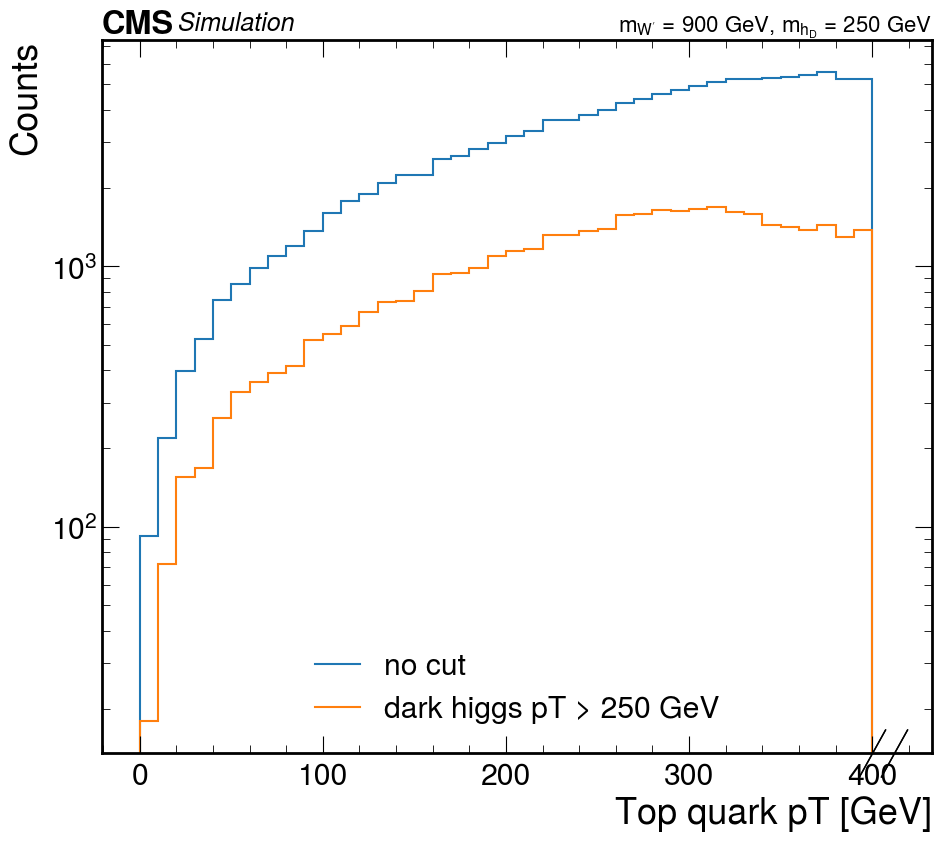

In [6]:
hist_name = 'h_pt' # 'h_pt'
fig, ax = plt.subplots(figsize=(10, 9))
hep.cms.text(loc=0, ax=ax, text="Simulation", fontsize=18)
out[hist_name][hist.loc('nocut'), :].plot1d(ax=ax, yerr=False, label='no cut')
out[hist_name][hist.loc('darkhiggs_ptcut'), :].plot1d(ax=ax, yerr=False, label='dark higgs pT > 250 GeV')

if hist_name == 'h_dr':
    ax.vlines(1.5, 0, 100, colors='green', linestyle='dashed')

ax.set_title('$m_{W\'}$ = '+str(MWprime)+' GeV, $m_{h_{D}}$ = '+str(MDarkHiggs)+' GeV', loc='right', fontsize=16)
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

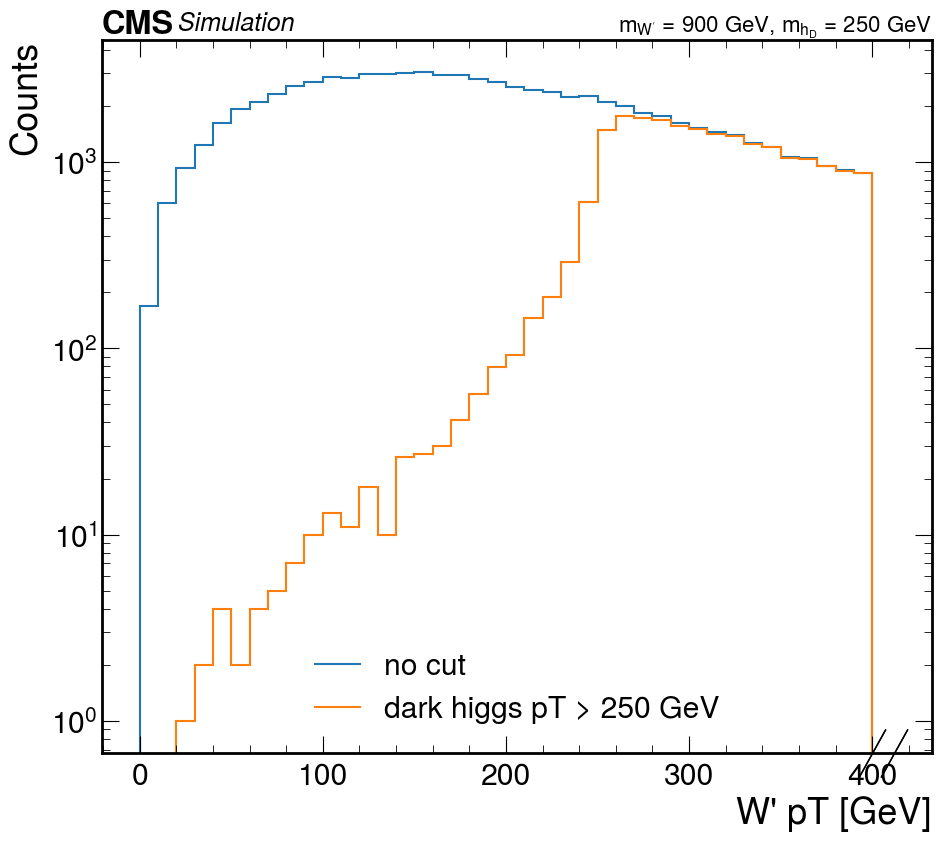

In [7]:
hist_name = 'h_mass_Wprime' # 'h_pt'
fig, ax = plt.subplots(figsize=(10, 9))
hep.cms.text(loc=0, ax=ax, text="Simulation", fontsize=18)
out[hist_name][hist.loc('nocut'), :].plot1d(ax=ax, yerr=False, label='no cut')
out[hist_name][hist.loc('darkhiggs_ptcut'), :].plot1d(ax=ax, yerr=False, label='dark higgs pT > 250 GeV')

if hist_name == 'h_dr':
    ax.vlines(1.5, 0, 100, colors='green', linestyle='dashed')

ax.set_title('$m_{W\'}$ = '+str(MWprime)+' GeV, $m_{h_{D}}$ = '+str(MDarkHiggs)+' GeV', loc='right', fontsize=16)
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

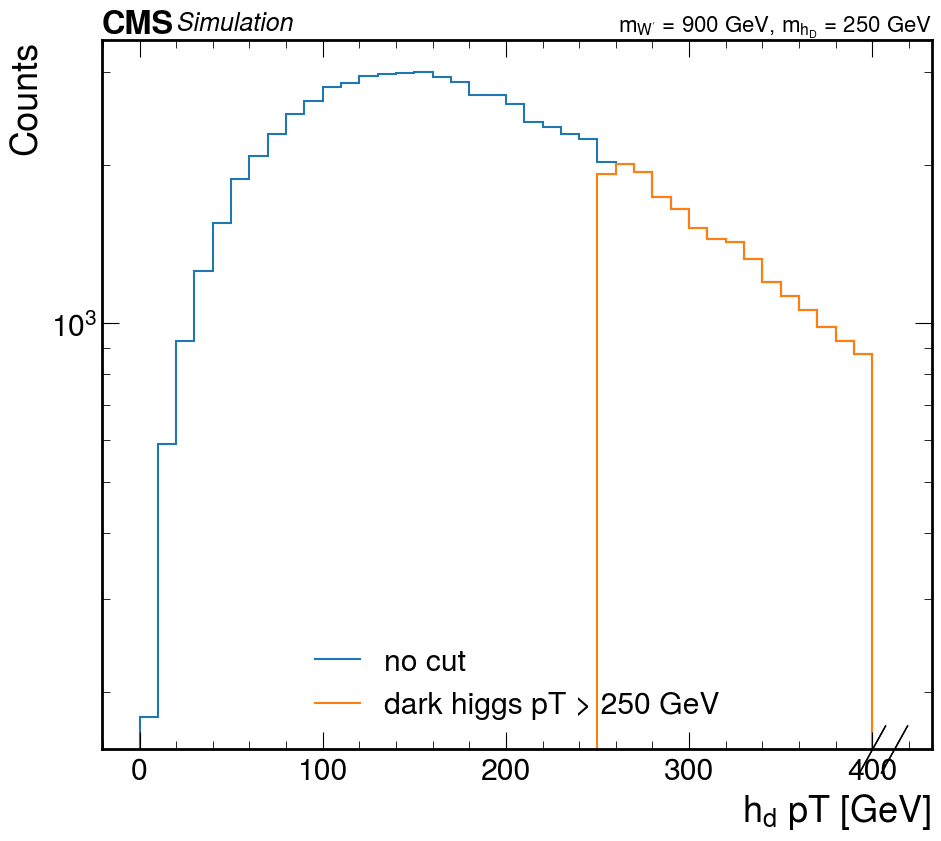

In [8]:
hist_name = 'h_Hd_pt' # 'h_pt'
fig, ax = plt.subplots(figsize=(10, 9))
hep.cms.text(loc=0, ax=ax, text="Simulation", fontsize=18)
out[hist_name][hist.loc('nocut'), :].plot1d(ax=ax, yerr=False, label='no cut')
out[hist_name][hist.loc('darkhiggs_ptcut'), :].plot1d(ax=ax, yerr=False, label='dark higgs pT > 250 GeV')

if hist_name == 'h_dr':
    ax.vlines(1.5, 0, 100, colors='green', linestyle='dashed')

ax.set_title('$m_{W\'}$ = '+str(MWprime)+' GeV, $m_{h_{D}}$ = '+str(MDarkHiggs)+' GeV', loc='right', fontsize=16)
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

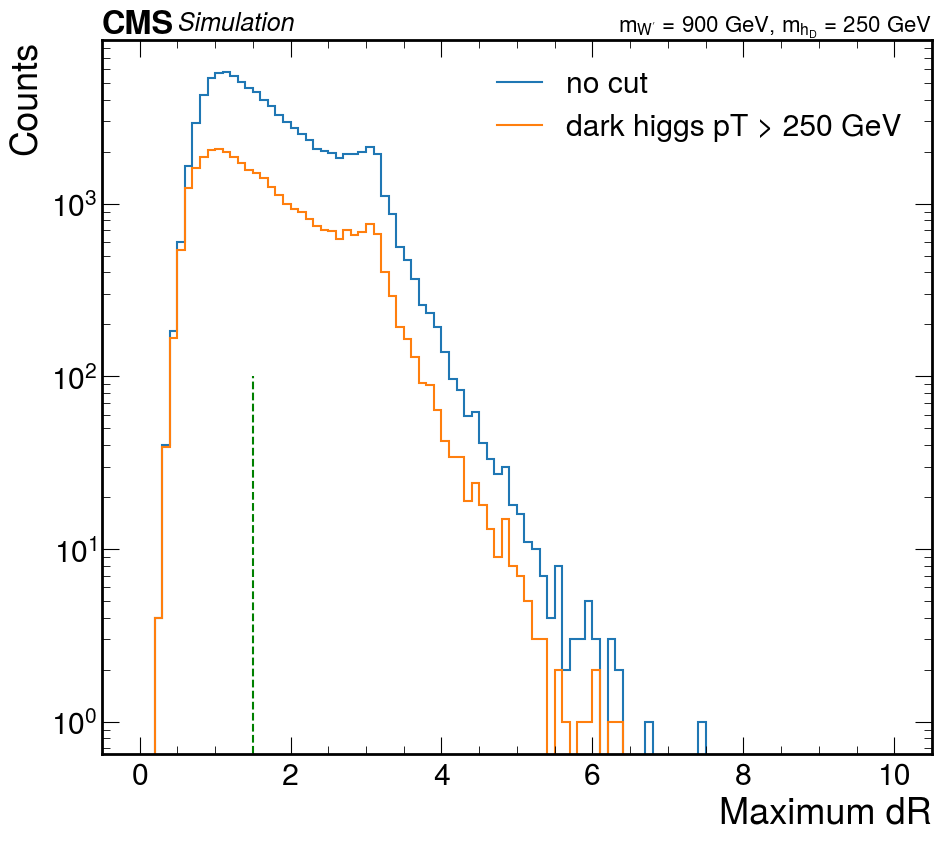

In [9]:
hist_name = 'h_dr' # 'h_pt'
fig, ax = plt.subplots(figsize=(10, 9))
hep.cms.text(loc=0, ax=ax, text="Simulation", fontsize=18)
out[hist_name][hist.loc('nocut'), :].plot1d(ax=ax, yerr=False, label='no cut')
out[hist_name][hist.loc('darkhiggs_ptcut'), :].plot1d(ax=ax, yerr=False, label='dark higgs pT > 250 GeV')

if hist_name == 'h_dr':
    ax.vlines(1.5, 0, 100, colors='green', linestyle='dashed')

ax.set_title('$m_{W\'}$ = '+str(MWprime)+' GeV, $m_{h_{D}}$ = '+str(MDarkHiggs)+' GeV', loc='right', fontsize=16)
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

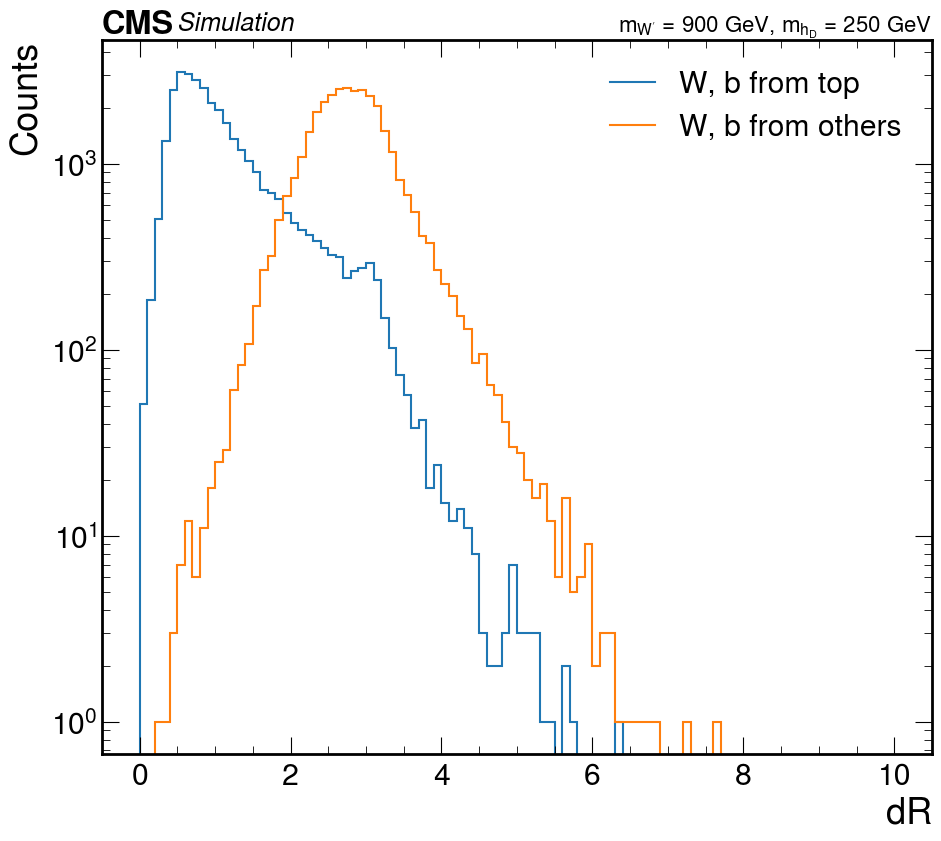

In [10]:
hist_name = 'h_dr_W' # 'h_pt'
fig, ax = plt.subplots(figsize=(10, 9))
hep.cms.text(loc=0, ax=ax, text="Simulation", fontsize=18)
out[hist_name][hist.loc('W, b from top'), :].plot1d(ax=ax, yerr=False, label='W, b from top')
out[hist_name][hist.loc('W, b from others'), :].plot1d(ax=ax, yerr=False, label='W, b from others')

if hist_name == 'h_dr':
    ax.vlines(1.5, 0, 100, colors='green', linestyle='dashed')

ax.set_title('$m_{W\'}$ = '+str(MWprime)+' GeV, $m_{h_{D}}$ = '+str(MDarkHiggs)+' GeV', loc='right', fontsize=16)
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

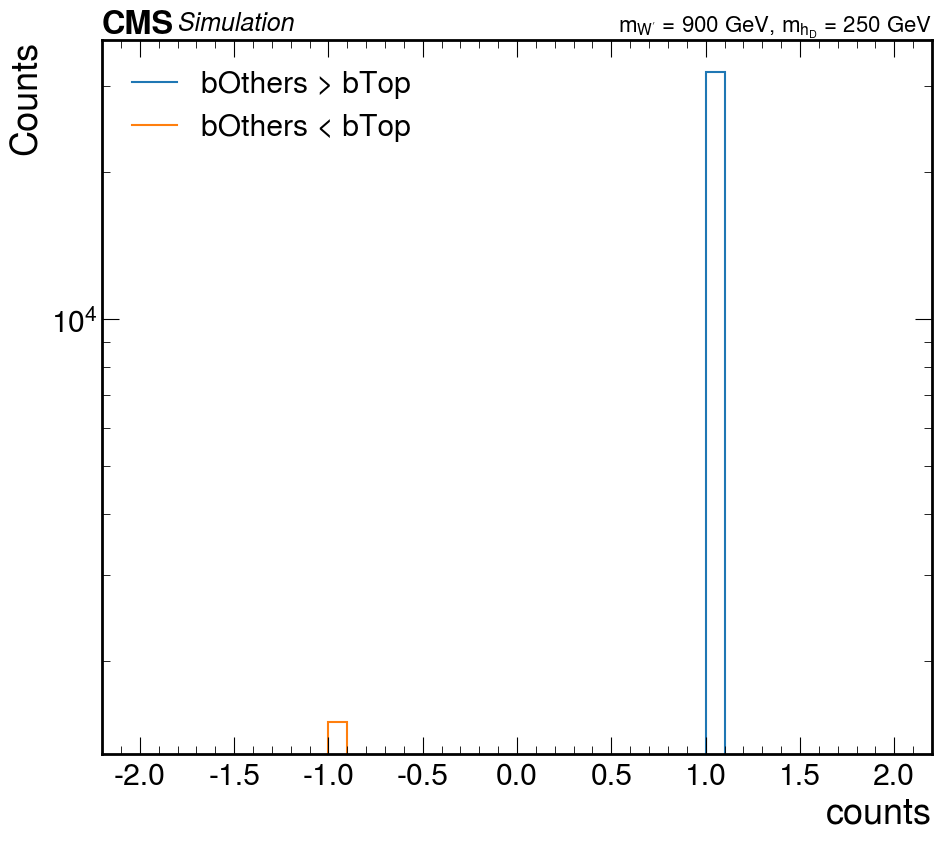

In [11]:
hist_name = 'h_dr_compare' # 'h_pt'
fig, ax = plt.subplots(figsize=(10, 9))
hep.cms.text(loc=0, ax=ax, text="Simulation", fontsize=18)
out[hist_name][hist.loc('dr_WbFromOthers > dr_WbFromTop'), :].plot1d(ax=ax, yerr=False, label='bOthers > bTop')
out[hist_name][hist.loc('dr_WbFromOthers < dr_WbFromTop'), :].plot1d(ax=ax, yerr=False, label='bOthers < bTop')

if hist_name == 'h_dr':
    ax.vlines(1.5, 0, 10, colors='green', linestyle='dashed')

ax.set_title('$m_{W\'}$ = '+str(MWprime)+' GeV, $m_{h_{D}}$ = '+str(MDarkHiggs)+' GeV', loc='right', fontsize=16)
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

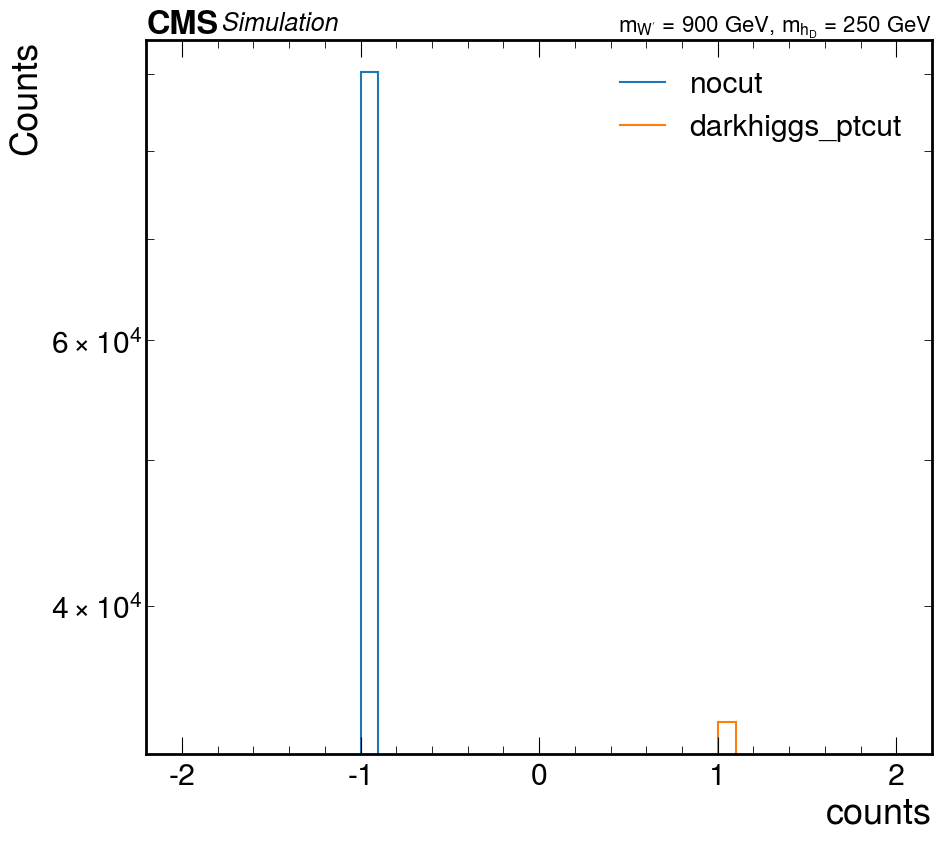

In [12]:
hist_name = 'h_cutflow' # 'h_pt'
fig, ax = plt.subplots(figsize=(10, 9))
hep.cms.text(loc=0, ax=ax, text="Simulation", fontsize=18)
out[hist_name][hist.loc('nocut'), :].plot1d(ax=ax, yerr=False, label='nocut')
out[hist_name][hist.loc('darkhiggs_ptcut'), :].plot1d(ax=ax, yerr=False, label='darkhiggs_ptcut')

if hist_name == 'h_dr':
    ax.vlines(1.5, 0, 10, colors='green', linestyle='dashed')

ax.set_title('$m_{W\'}$ = '+str(MWprime)+' GeV, $m_{h_{D}}$ = '+str(MDarkHiggs)+' GeV', loc='right', fontsize=16)
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

In [13]:
out['h_dr_compare'][hist.loc('dr_WbFromOthers > dr_WbFromTop'), :].values().sum()/(out['h_dr_compare'][hist.loc('dr_WbFromOthers > dr_WbFromTop'), :].values().sum() + out['h_dr_compare'][hist.loc('dr_WbFromOthers < dr_WbFromTop'), :].values().sum())

0.9552261066698484

In [14]:
out['h_dr_compare'][hist.loc('dr_WbFromOthers < dr_WbFromTop'), :].values().sum()/(out['h_dr_compare'][hist.loc('dr_WbFromOthers > dr_WbFromTop'), :].values().sum() + out['h_dr_compare'][hist.loc('dr_WbFromOthers < dr_WbFromTop'), :].values().sum())

0.04477389333015153

In [15]:
out['h_cutflow'][hist.loc('nocut'), :].values().sum()

90247.0

In [16]:
out['h_cutflow'][hist.loc('darkhiggs_ptcut'), :].values().sum()

33524.0

In [17]:
out['h_dr_W'][hist.loc('W, b from others'), :][:1.5j].values().sum()

364.0

In [18]:
out['h_dr_W'][hist.loc('W, b from top'), :].values().sum()

33524.0

In [19]:
out['h_dr_W'][hist.loc('W, b from others'), :].values().sum()

33524.0

In [20]:
out['h_dr_W'][hist.loc('W, b from top'), :].values()

array([5.100e+01, 1.850e+02, 5.070e+02, 1.322e+03, 2.487e+03, 3.099e+03,
       3.041e+03, 2.834e+03, 2.559e+03, 2.136e+03, 1.940e+03, 1.662e+03,
       1.354e+03, 1.189e+03, 1.037e+03, 9.010e+02, 7.230e+02, 6.970e+02,
       6.440e+02, 5.410e+02, 4.820e+02, 4.410e+02, 4.120e+02, 3.840e+02,
       3.540e+02, 3.220e+02, 3.140e+02, 2.440e+02, 2.640e+02, 2.740e+02,
       2.920e+02, 2.370e+02, 1.490e+02, 1.020e+02, 7.300e+01, 5.700e+01,
       3.800e+01, 4.200e+01, 1.800e+01, 2.400e+01, 1.500e+01, 1.200e+01,
       1.400e+01, 1.100e+01, 8.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
       3.000e+00, 7.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 1.000e+00,
       1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

In [21]:
out['h_dr_W'][hist.loc('W, b from others'), :].values()

array([0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 7.000e+00,
       1.200e+01, 6.000e+00, 1.100e+01, 1.800e+01, 2.500e+01, 2.900e+01,
       6.100e+01, 8.300e+01, 1.070e+02, 1.720e+02, 2.690e+02, 3.180e+02,
       4.990e+02, 6.720e+02, 8.420e+02, 1.089e+03, 1.490e+03, 1.897e+03,
       2.158e+03, 2.350e+03, 2.519e+03, 2.564e+03, 2.476e+03, 2.483e+03,
       2.327e+03, 2.047e+03, 1.506e+03, 1.151e+03, 8.180e+02, 6.790e+02,
       5.520e+02, 4.070e+02, 3.760e+02, 2.700e+02, 2.270e+02, 1.950e+02,
       1.520e+02, 1.290e+02, 8.500e+01, 9.500e+01, 6.500e+01, 5.700e+01,
       4.100e+01, 3.000e+01, 2.800e+01, 2.000e+01, 1.600e+01, 1.900e+01,
       1.200e+01, 6.000e+00, 1.600e+01, 5.000e+00, 6.000e+00, 9.000e+00,
       2.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

In [22]:
out['h_dr_W'][hist.loc('W, b from top'), :].values()<out['h_dr_W'][hist.loc('W, b from others'), :].values()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [23]:
#save everything in a pickle file
import pickle
filename = 'pickles/' + 'MWprime'+str(MWprime)+'_MDarkHiggs'+str(MDarkHiggs)+'.pkl'
with open(filename, 'wb') as output:
    pickle.dump(out, output, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
#open pickle file if needed
with open(filename, 'rb') as input:
    hists = pickle.load(input)

In [25]:
hists

{'h_mass': Hist(Regular(40, 0, 400, name='mass', label='mass [GeV]'), storage=Double()) # Sum: 180494.0 (360988.0 with flow),
 'h_mass_Wprime': Hist(
   StrCategory(['nocut', 'darkhiggs_ptcut'], growth=True, name='cut'),
   Regular(40, 0, 400, name='mass_W', label="W' pT [GeV]"),
   storage=Double()) # Sum: 99627.0 (123771.0 with flow),
 'h_Hd_pt': Hist(
   StrCategory(['nocut', 'darkhiggs_ptcut'], growth=True, name='cut'),
   Regular(40, 0, 400, name='mass_W', label='$h_{d}$ pT [GeV]'),
   storage=Double()) # Sum: 98995.0 (123771.0 with flow),
 'h_pt': Hist(
   StrCategory(['nocut', 'darkhiggs_ptcut'], growth=True, name='cut'),
   Regular(40, 0, 400, name='pT', label='Top quark pT [GeV]'),
   storage=Double()) # Sum: 162333.0 (248640.0 with flow),
 'h_dr': Hist(
   StrCategory(['nocut', 'darkhiggs_ptcut'], growth=True, name='cut'),
   Regular(100, 0, 10, name='dr', label='Maximum dR'),
   storage=Double()) # Sum: 123771.0,
 'h_dr_W': Hist(
   StrCategory(['W, b from top', 'W, b from o

In [26]:
hists['h_cutflow'][hist.loc('nocut'), :].values().sum()

90247.0